# Setup

In [1]:
import numpy as np
import os
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Flatten, Activation, Conv2D, Dropout, BatchNormalization, MaxPool2D

from keras.callbacks import TensorBoard
from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,regularizers
from keras.utils import to_categorical
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import cv2
import shutil
import platform

from PIL import Image
import tensorflow as tf

Using TensorFlow backend.


In [2]:
#For using GPU to improving computation time
physical_devices = tf.config.list_physical_devices('GPU') 
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config = config)

In [ ]:
tf.device('/cpu:0')

In [4]:
#Needed check system
platform.system()

'Windows'

https://www.kaggle.com/grassknoted/asl-alphabet

# Path

In [5]:
if platform.system() == 'Windows':
    train_path = "asl_alphabet_train\\asl_alphabet_train\\"
    test_path = 'asl_alphabet_test\\asl_alphabet_test\\'
if platform.system() == 'Darwin':
    train_path = 'asl-alphabet/asl_alphabet_train/asl_alphabet_train/'
    test_path = 'asl-alphabet/asl_alphabet_test/asl_alphabet_test/'

This quick way for me to label all my classes

In [6]:
CATEGORIES = []

for i in range(0,26):
    CATEGORIES.append(chr(ord('A') + i))

CATEGORIES.append('space')
CATEGORIES.append('nothing')
CATEGORIES.append('del')

# Preprocessing Data

In [7]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',validation_split=0.2, rescale=1/255.0)

In [56]:
generator = ImageDataGenerator(validation_split=0.2, rescale=1/255.0)
generator1 = ImageDataGenerator(validation_split=0.2, rescale=1/255.0)
train_batches = datagen.flow_from_directory(train_path,
                                              target_size=(200,200),
                                              classes = CATEGORIES,
                                              color_mode='rgb',
                                              batch_size=25,
                                              subset='training')
valid_batches = generator1.flow_from_directory(train_path,
                                              target_size=(200,200),
                                              classes = CATEGORIES,
                                              color_mode='rgb',
                                              batch_size=15,
                                              subset= 'validation')


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [57]:
test_path

'asl_alphabet_test\\asl_alphabet_test\\'

In [58]:
test_labels = []
test_images = []
width = 200.0
height = 200.0
for name in os.listdir(test_path):
    temp_test_labels = [0 for i in range(29)]
    if name[-3:] == 'jpg':
        category, _ = name.split('_')
        temp_test_labels[train_batches.class_indices[category]] = 1
        test_labels.append(temp_test_labels)
        with Image.open(test_path + name) as image:
            newsize = (200, 200)
            #width,height = image.size
            image = image.resize(newsize)
            test_images.append(np.array(image)/ 255.0)
        
       
        
    
        
    

In [59]:
images, labels = next(train_batches)


In [60]:
def plot_images(images):
    for i in range(5):
        plt.imshow((images[i]))
        plt.title(CATEGORIES[int(np.where(labels[i] == 1)[0])])
        plt.show()

# Plotting Images

Can verify labels are correct with provided chart

In [61]:
%%html
<img src="RefImg.jpg" alt="ASL-Alphabet">

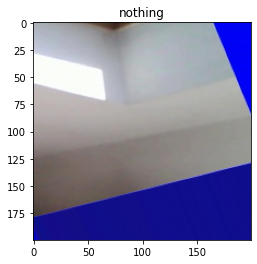

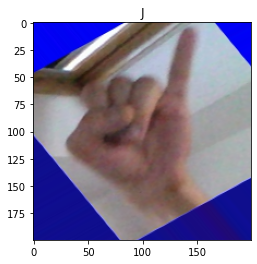

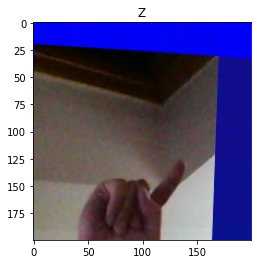

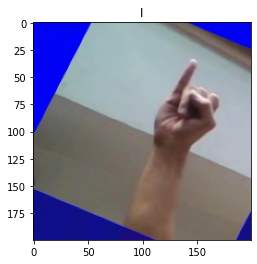

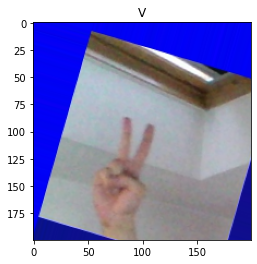

In [62]:
plot_images(images)

# Build Model

In [63]:
model = Sequential()
model.add(Conv2D(64, kernel_size=4, strides=1, activation='relu', input_shape=(200,200,3)))

model.add(Conv2D(64, kernel_size=4, strides=2, activation='relu'))
#model.add(Dropout(0.5))

model.add(Conv2D(128, kernel_size=4, strides=1, activation='relu'))
model.add(Conv2D(128, kernel_size=4, strides=2, activation='relu'))
#model.add(Dropout(0.5))

model.add(Conv2D(256, kernel_size=4, strides=1, activation='relu'))
model.add(Conv2D(256, kernel_size=4, strides=2, activation='relu'))

model.add(BatchNormalization())

model.add(Flatten())
#model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_regularizer = regularizers.l2(0.001)))
model.add(Dense(29, activation='softmax'))

In [64]:
model.compile(optimizer= 'sgd', loss= "categorical_crossentropy", metrics=['accuracy'])

In [ ]:
model.fit_generator(train_batches,
                    steps_per_epoch=30,
                    validation_data=valid_batches,
                    validation_steps=10,
                    epochs=20,
                    verbose=2)

vgg16_model = keras.applications.vgg16.VGG16()


# Modify Model


In [65]:
vgg16_model = keras.applications.vgg16.VGG16(weights='imagenet',
            include_top=False,
            input_shape=(200, 200, 3))



In [66]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [67]:
model = Sequential()
#removing last layer and add mine
model.add(vgg16_model)
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(29, activation='softmax'))

In [68]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)               3686600   
_________________________________________________________________
dense_7 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_8 (Dense)              (None, 29)                5829      
Total params: 18,447,317
Trainable params: 18,447,317
Non-trainable params: 0
_________________________________________________________________


In [69]:
model.compile(optimizer= 'sgd', loss= "categorical_crossentropy", metrics=['accuracy'])

In [76]:
history = model.fit_generator(train_batches,
                    steps_per_epoch=25,
                    validation_data=valid_batches,
                    validation_steps=15,
                    epochs=20,
                    verbose=2)

Epoch 1/20
 - 5s - loss: 0.4470 - accuracy: 0.8592 - val_loss: 0.7327 - val_accuracy: 0.8800
Epoch 2/20
 - 5s - loss: 0.4604 - accuracy: 0.8608 - val_loss: 0.1631 - val_accuracy: 0.8978
Epoch 3/20
 - 5s - loss: 0.3263 - accuracy: 0.8928 - val_loss: 0.3100 - val_accuracy: 0.8222
Epoch 4/20
 - 5s - loss: 0.3432 - accuracy: 0.8816 - val_loss: 0.7132 - val_accuracy: 0.8044
Epoch 5/20
 - 5s - loss: 0.4273 - accuracy: 0.8640 - val_loss: 0.0738 - val_accuracy: 0.9156
Epoch 6/20
 - 5s - loss: 0.4216 - accuracy: 0.8608 - val_loss: 0.4539 - val_accuracy: 0.8178
Epoch 7/20
 - 5s - loss: 0.3122 - accuracy: 0.8976 - val_loss: 0.4521 - val_accuracy: 0.8711
Epoch 8/20
 - 5s - loss: 0.3989 - accuracy: 0.8752 - val_loss: 0.0320 - val_accuracy: 0.9378
Epoch 9/20
 - 5s - loss: 0.3041 - accuracy: 0.9120 - val_loss: 0.1410 - val_accuracy: 0.9511
Epoch 10/20
 - 5s - loss: 0.3953 - accuracy: 0.8816 - val_loss: 0.3156 - val_accuracy: 0.9422
Epoch 11/20
 - 5s - loss: 0.3234 - accuracy: 0.9056 - val_loss: 0.166

# Testing Model

In [77]:
model.evaluate(np.array(test_images),np.array(test_labels))

28/28 [==============================] - 0s 3ms/step


[0.020927807316184044, 1.0]

# Some useful Functions 

In [22]:
def show_guess(prediction, top_k = 3):
    mapping = dict()
    prediction = np.round(prediction, decimals= 3)
    for i in range(prediction.size):
        mapping[CATEGORIES[i]] = prediction[0][i]
    return sorted(mapping.items(), key= lambda x: x[1], reverse=True)[:top_k]
    

In [23]:
def real_image_test(image, top_k = 3):
    img = Image.open(image)
    img = img.resize((200, 200))
    img_arr = np.array(img)/ 255.0
    image = np.expand_dims(img_arr, axis = 0)
    print(f"Model has predicted {CATEGORIES[model.predict(image).argmax()]}")
    print(show_guess(model.predict(image), top_k= top_k))
    plt.imshow(image[0])
    plt.show()

In [24]:
def merge_test(a,b):
    return [(a[i], b[i]) for i in range(len(a))]

In [25]:

def verify_test_image(TEST_IMAGES,image_number=0):
    image , label = TEST_IMAGES[image_number]
    plt.imshow(image)
    img = np.expand_dims(image, axis = 0)
    prediction = model.predict(img)
    print(f"Model has predicted {CATEGORIES[prediction.argmax()]}")
    print(show_guess(model.predict(img)))
    actual = CATEGORIES[np.argmax(label)]
    plt.title(f"This is the image of an {actual}")
    plt.imshow(image)
     

# Testing Model

In [78]:
TEST_IMAGES = merge_test(test_images,test_labels)


Model has predicted K
[('K', 0.985), ('V', 0.014), ('W', 0.001)]


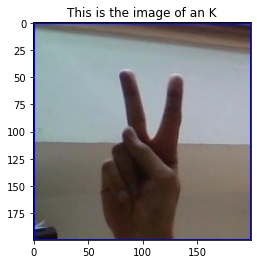

In [79]:
verify_test_image(TEST_IMAGES,10)

# Visualize Model Training History

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


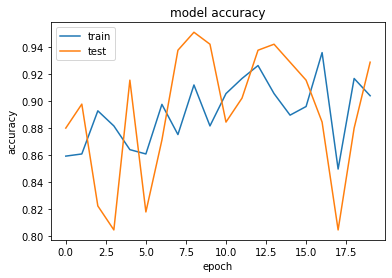

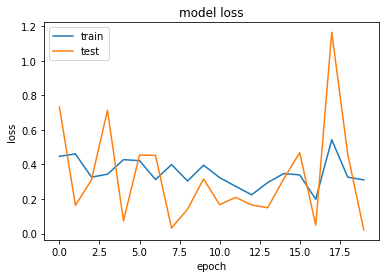

In [92]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model has predicted Y
[('Y', 0.817), ('J', 0.084), ('L', 0.055)]


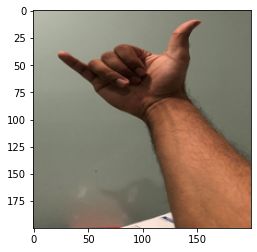

In [81]:
real_image_test('Y_Tyron4.jpg')

Model has predicted C
[('C', 0.997), ('O', 0.001), ('del', 0.001)]


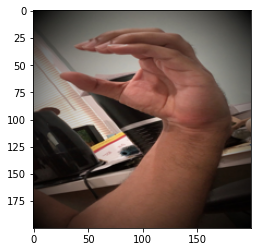

In [82]:
real_image_test('C_Tyron1.jpg')

Model has predicted Y
[('Y', 0.999), ('J', 0.001), ('A', 0.0)]


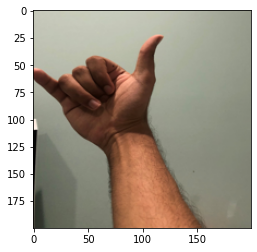

In [91]:
real_image_test('Y_Tyron2.jpg')

Model has predicted B
[('B', 1.0), ('A', 0.0), ('C', 0.0)]


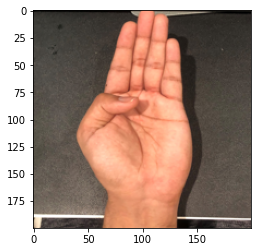

In [94]:
real_image_test('B_Tyron9.jpg')

In [85]:
model.save('Best_Model_So_Far_2020_Tyron.h5')

# Load Trained Model

In [32]:
from keras.models import load_model

In [95]:
model_test = load_model('Best_Model_So_Far_2020_Tyron.h5')

In [96]:
model_test.evaluate(np.array(test_images),np.array(test_labels))

28/28 [==============================] - 0s 4ms/step


[0.020927807316184044, 1.0]